<a href="https://colab.research.google.com/github/ahdhani/MACD_Convergence/blob/main/MACDTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import datetime as dt
# from datetime import datetime
import matplotlib.pyplot as plt
import requests


def getOHLC(pair,timeframe):
  base_url = "https://public.coindcx.com/market_data/candles?interval="+ timeframe +"&pair="+pair
  response = requests.get(base_url)
  data = response.json()
  return data

def parseOHLCtoDf(data):
  df = pd.DataFrame(data[::-1])
  if len(df)==0:
    return df
  
  return df[['close', 'time']]
  # return df[['close', 'time']].set_index('time')
  # df[::-1]
  # return df[['close', 'time', 'volume']]

def getParsedOHLC(pair,timeframe):
  data = getOHLC(pair,timeframe)
  return parseOHLCtoDf(data)

def getMACD(df):
  exp1 = df['close'].ewm(span=12, adjust=False).mean()
  exp2 = df['close'].ewm(span=26, adjust=False).mean()
  macd = exp1 - exp2
  df['macd'] = macd
  df['signal'] = macd.ewm(span=9, adjust=False).mean()
  # return df

def crossover(df):
  trough = []
  peak = []
  maxima =  []
  minima = []

  flag = -1
  for i in range(0,len(df)):
    #if MACD > signal  then buy else sell
      if df['macd'][i] > df['signal'][i]:
        if flag != 1:
          if df['macd'][i-1]<0:
            trough.append(df['signal'][i-1])
            minima.append([df['signal'][i-1],df['time'][i-1]])
          else:
            trough.append(np.nan)
          peak.append(np.nan)
          flag = 1
        else:
          trough.append(np.nan)
          peak.append(np.nan)

      elif df['macd'][i] < df['signal'][i]: 
        if flag != 0:
          if df['macd'][i-1]>0:
            maxima.append([df['macd'][i-1],df['time'][i-1]])
            peak.append(df['signal'][i-1])
          else:
            peak.append(np.nan)
          trough.append(np.nan)
          flag = 0
        else:
          trough.append(np.nan)
          peak.append(np.nan)
      else: #Handling nan values
        trough.append(np.nan)
        peak.append(np.nan)

  df['trough'] = trough
  df['peak'] = peak

  return maxima,minima
  
  # return (sigPriceBuy, sigPriceSell)
def plotMACD(df,pair):
  plt.figure(figsize=(20,8))
  df.macd.plot(label='MACD', color='g')
  ax = df.signal.plot(label='Signal Line', color='r')
  df.close.plot(ax=ax, secondary_y=True, label=pair)

  ax.scatter(df.index, df.trough , color = 'green', label='Buy Signal', marker = '^', alpha = 1)
  ax.scatter(df.index, df.peak , color = 'red', label='Sell Signal', marker = 'v', alpha = 1)

  ax.set_ylabel('MACD')
  ax.right_ax.set_ylabel('Price $')
  ax.set_xlabel('time')
  lines = ax.get_lines() + ax.right_ax.get_lines()
  ax.legend(lines, [l.get_label() for l in lines], loc='upper left')

  # plt.plot_date(times, data, fmt='H')
  # plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 90)

  plt.show()

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')
       return 0,0

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def trendDir(ts1,ts2,df):
  close1 = df.loc[(df["time"]==ts1)]
  close2 = df.loc[(df["time"]==ts2)]
  print(close1["close"])
  print(close2["close"])
  # print(close2[0])
  # print(close2)
  return 2-1

def main1(pair,timeframe,seektime):
  df = getParsedOHLC(pair,timeframe)
  # print(df.head())
  if len(df)!=500:
    return None
  getMACD(df)
  peak,trough = crossover(df)
  x,y = line_intersection((peak[-1],peak[-2]),(trough[-1],trough[-2]))
  lastTime = df.at[499,'time']
  if y>lastTime and y<(lastTime+seektime):
    # print(trendDir(peak[-1][1],peak[-2][1],df))
    print(peak[-1][0]-peak[-2][0])
    print(dt.datetime.fromtimestamp((y/1000)+19800))
    plotMACD(df,pair)
    return [dt.datetime.fromtimestamp((y/1000)+19800),pair]
  return None

main1('B-MATIC_USDT',"15m",15000000)

def main2(pair,timeframe="15m"):
  df = getParsedOHLC(pair,timeframe)
  if len(df)==0:
    return None
  getMACD(df)
  peak,trough = crossover(df)
  x,y = line_intersection((peak[-1],peak[-2]),(trough[-1],trough[-2]))
  print(peak[-1][0]-peak[-2][0])
  print(dt.datetime.fromtimestamp((y/1000)+19800))
  plotMACD(df,pair)

def macdDriver(timeframe="15m",seektime=4):
  marketCoinPairs = ['B-MATIC_USDT','B-ADA_USDT','B-ONG_USDT','B-OGN_USDT','B-KSM_USDT','B-XRP_USDT','B-NANO_USDT','B-SUPER_USDT','B-TKO_USDT',
                    'B-ETH_USDT','B-BNB_USDT','B-BTC_USDT','B-XLM_USDT','B-DOT_USDT','B-TRX_USDT','B-DOGE_USDT','B-ONE_USDT','B-TFUEL_USDT',
                    'B-THETA_USDT','B-ETC_USDT','B-SHIB_USDT','B-OM_USDT','B-OMG_USDT','B-ICP_USDT','B-SOL_USDT','B-COTI_USDT','B-SKL_USDT',
                    'B-BLZ_USDT','B-UNFI_USDT','B-CTSI_USDT','B-UNI_USDT','B-EOS_USDT','B-KNC_USDT','B-RAMP_USDT','B-YFI_USDT','B-YFII_USDT',
                    'B-VET_USDT','B-CELR_USDT','B-1INCH_USDT','B-GXC_USDT','B-FIL_USDT']

  res = []
  for x in marketCoinPairs:
    print(x+timeframe)
    returnData = main1(x,timeframe,seektime=3600000*seektime)
    if returnData != None:
      res.append(returnData)
  res.sort(key = lambda x: x[0])
  print("Result timeframe : " + timeframe)
  print(res)
  print("\n")

# main1('B-ADA_USDT',"15m",15000000)

# macdDriver(timeframe="15m")



B-MATIC_USDT15m
B-ADA_USDT15m
B-ONG_USDT15m
B-OGN_USDT15m
-0.0042715581903242095
2021-07-27 00:22:38.071791


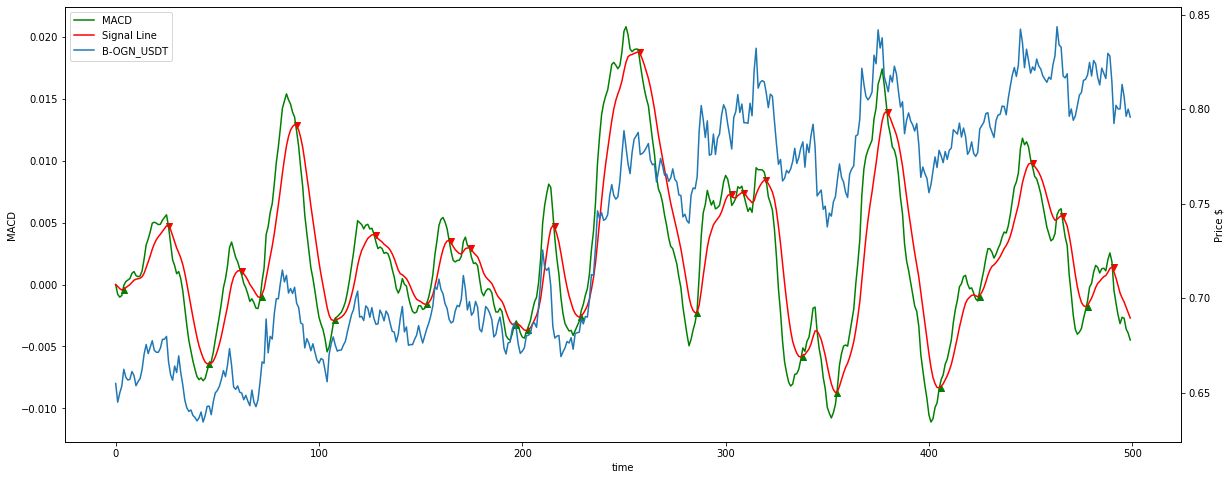

B-KSM_USDT15m
B-XRP_USDT15m
B-NANO_USDT15m
B-SUPER_USDT15m
B-TKO_USDT15m
B-ETH_USDT15m
B-BNB_USDT15m
-5.17805073775645
2021-07-26 23:40:57.650795


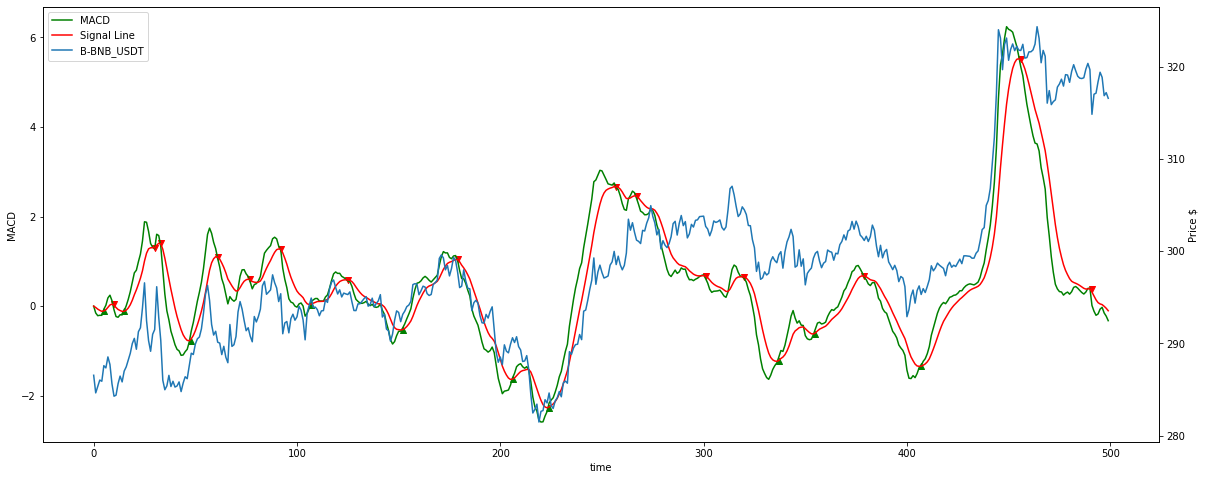

B-BTC_USDT15m
-735.1820638273857
2021-07-26 22:40:41.073793


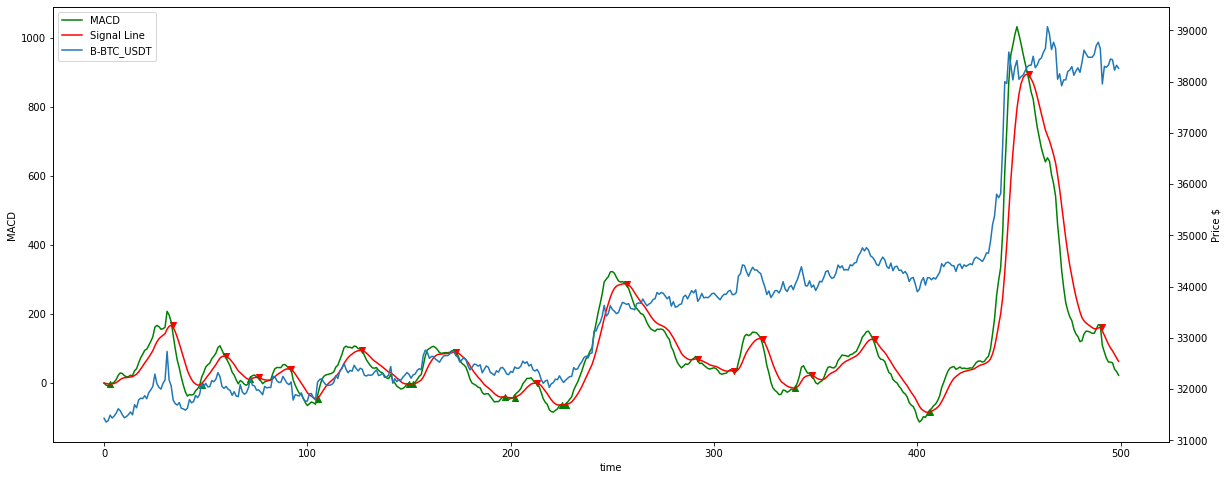

B-XLM_USDT15m
B-DOT_USDT15m
B-TRX_USDT15m
B-DOGE_USDT15m
B-ONE_USDT15m
B-TFUEL_USDT15m
B-THETA_USDT15m
-0.0402475447730124
2021-07-27 00:17:12.105915


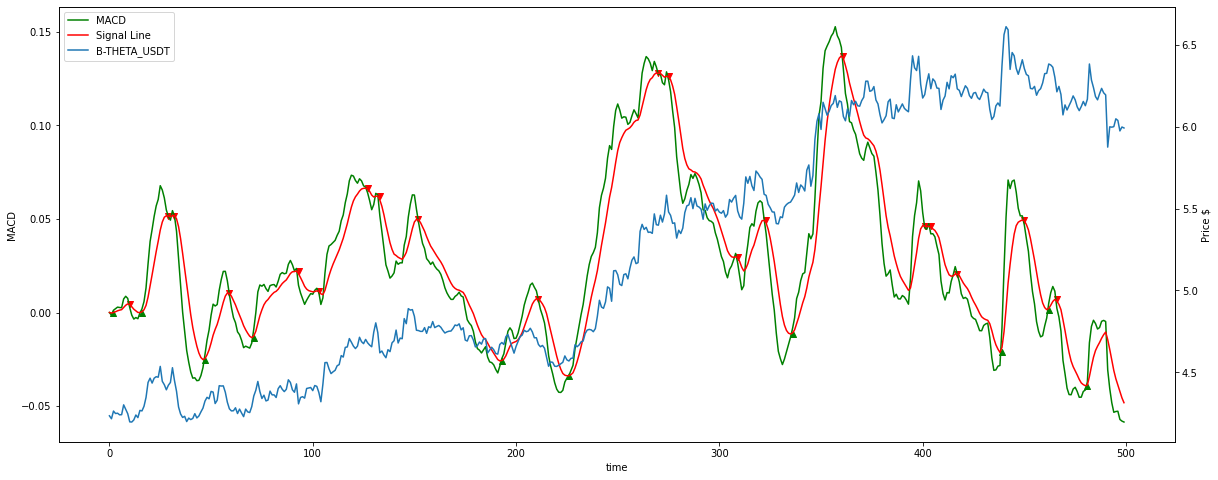

B-ETC_USDT15m
B-SHIB_USDT15m
B-OM_USDT15m
B-OMG_USDT15m
B-ICP_USDT15m
B-SOL_USDT15m
B-COTI_USDT15m
B-SKL_USDT15m
B-BLZ_USDT15m
B-UNFI_USDT15m
-0.18732388438964875
2021-07-26 20:36:27.264877


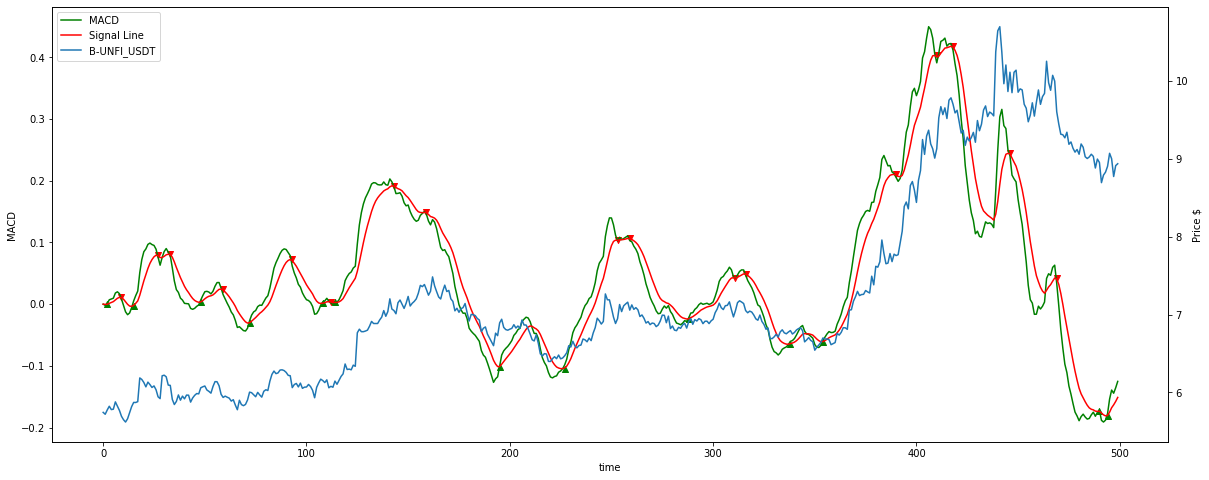

B-CTSI_USDT15m
B-UNI_USDT15m
B-EOS_USDT15m
B-KNC_USDT15m
B-RAMP_USDT15m
-0.005446545711001671
2021-07-26 22:56:28.677697


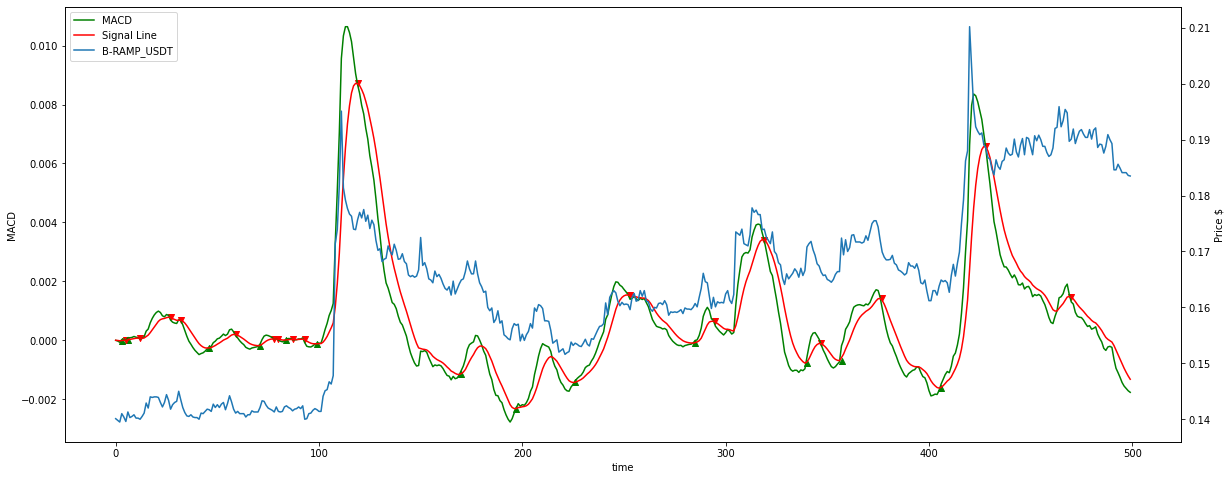

B-YFI_USDT15m
B-YFII_USDT15m
B-VET_USDT15m
B-CELR_USDT15m
B-1INCH_USDT15m
B-GXC_USDT15m
B-FIL_USDT15m
Result timeframe : 15m
[[datetime.datetime(2021, 7, 26, 20, 36, 27, 264877), 'B-UNFI_USDT'], [datetime.datetime(2021, 7, 26, 22, 40, 41, 73793), 'B-BTC_USDT'], [datetime.datetime(2021, 7, 26, 22, 56, 28, 677697), 'B-RAMP_USDT'], [datetime.datetime(2021, 7, 26, 23, 40, 57, 650795), 'B-BNB_USDT'], [datetime.datetime(2021, 7, 27, 0, 17, 12, 105915), 'B-THETA_USDT'], [datetime.datetime(2021, 7, 27, 0, 22, 38, 71791), 'B-OGN_USDT']]


B-MATIC_USDT30m
B-ADA_USDT30m
B-ONG_USDT30m
B-OGN_USDT30m
B-KSM_USDT30m
B-XRP_USDT30m
B-NANO_USDT30m
B-SUPER_USDT30m
B-TKO_USDT30m
B-ETH_USDT30m
B-BNB_USDT30m
B-BTC_USDT30m
B-XLM_USDT30m
B-DOT_USDT30m
B-TRX_USDT30m
B-DOGE_USDT30m
B-ONE_USDT30m
B-TFUEL_USDT30m
B-THETA_USDT30m
B-ETC_USDT30m
B-SHIB_USDT30m
B-OM_USDT30m
B-OMG_USDT30m
B-ICP_USDT30m
B-SOL_USDT30m
B-COTI_USDT30m
B-SKL_USDT30m
B-BLZ_USDT30m
B-UNFI_USDT30m
B-CTSI_USDT30m
B-UNI_USDT30m
B-EOS_USDT30m
B-K

In [ ]:
# Timeframes = ["1m", "5m", "15m", "30m", "1h", "2h", "4h", "1d"]
timeFrames = ["15m", "30m", "1h", "2h", "4h", "1d"]
for time in timeFrames:
  macdDriver(timeframe=time)

5m
-0.00010169269642737455
2021-07-26 14:11:44.862780


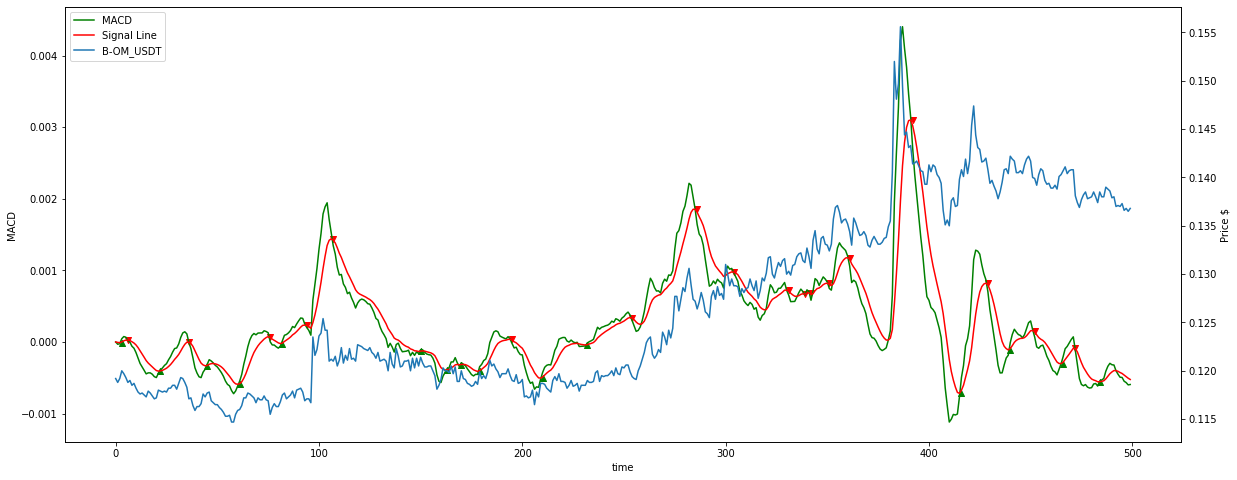

15m
0.0008261302719410613
2021-07-25 23:09:37.914280


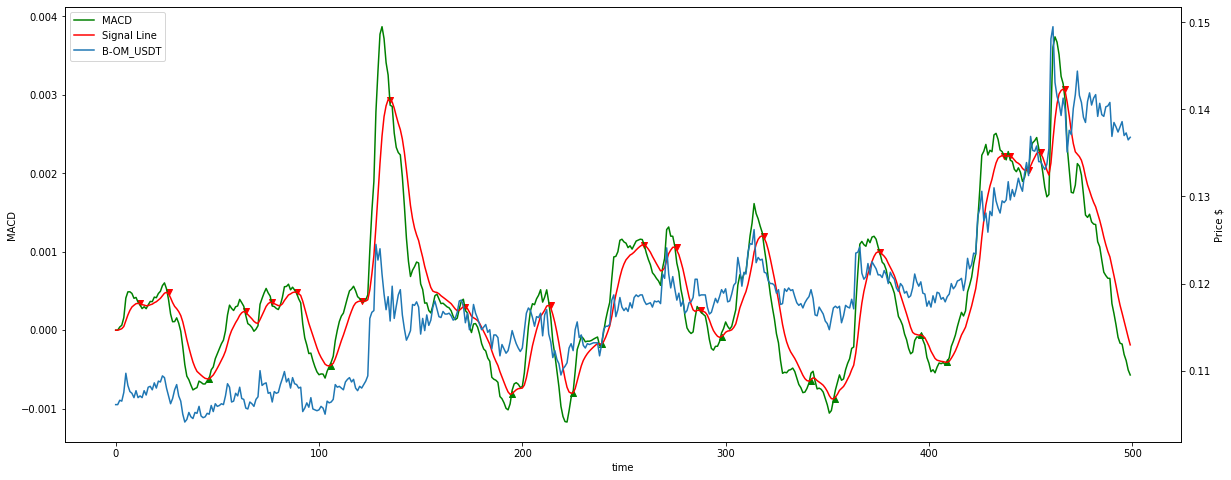

1h
0.004572335986083573
2021-07-24 16:26:44.911474


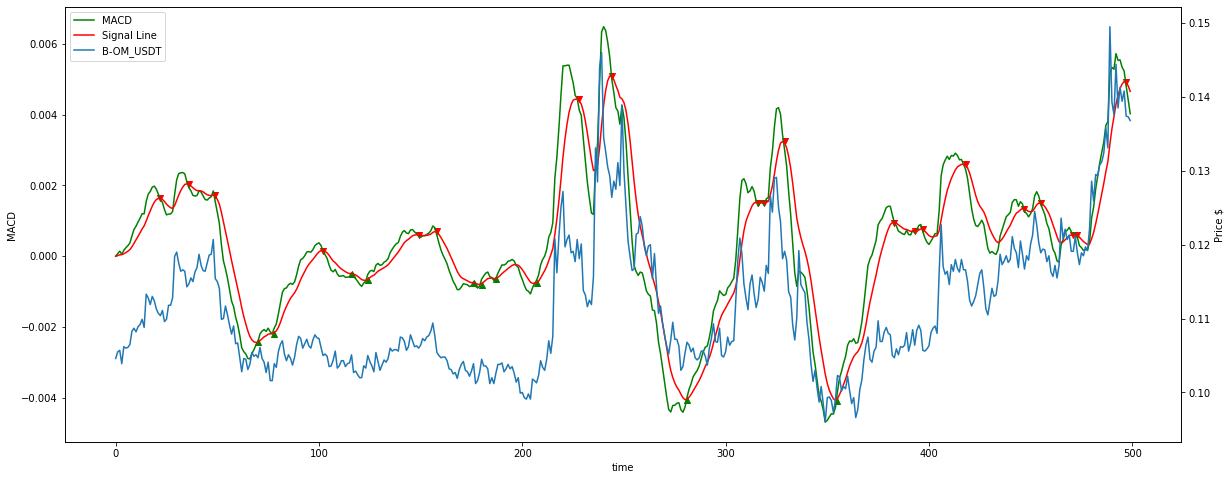

4h
-0.004144446788746564
2021-07-22 21:14:48.709337


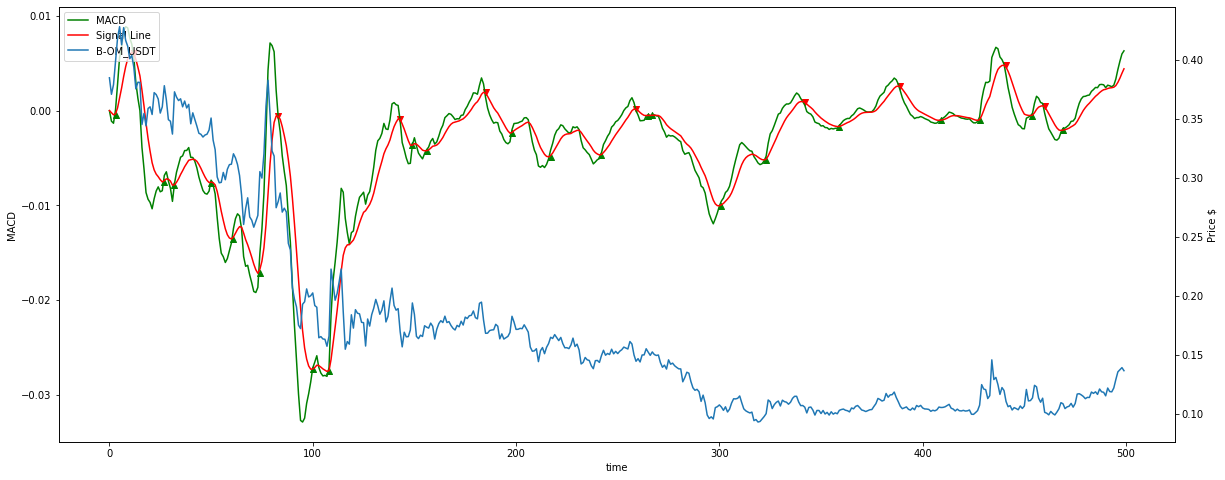

In [ ]:
# def main2(pair,timeframe="15m"):
#   df = getParsedOHLC(pair,timeframe)
#   if len(df)==0:
#     return None
#   getMACD(df)
#   peak,trough = crossover(df)
#   x,y = line_intersection((peak[-1],peak[-2]),(trough[-1],trough[-2]))
#   print(peak[-1][0]-peak[-2][0])
#   print(dt.datetime.fromtimestamp((y/1000)+19800))
#   plotMACD(df,pair)

timeframe = ["5m","15m","30m","1h","2h","4h",]
timeframe1 = ["5m","15m","1h","4h",]

for x in timeframe1:
  print(x)
  main2('B-OM_USDT',x)
